## **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualisasi sebaran data
import pickle,nltk,re # save pretrained model, preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support 
from sklearn.svm import SVC # library support vector machine
from sklearn.model_selection import KFold,train_test_split, cross_val_score # import K-Fold Cross Validation, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB #Import Gaussian Naive Bayes
from sklearn.ensemble import RandomForestClassifier # Import Random Forest
from sklearn.linear_model import LogisticRegression # Import Logistic Regression
from gensim.models import Word2Vec # untuk ekstraksi fitur
from nltk.corpus import stopwords # untuk melakukan stopword removal
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # untuk melakukan stemming
from nltk.tokenize import word_tokenize # untuk melakukan tokenisasi
from imblearn.over_sampling import SMOTE # untuk melakukan SMOTE
from collections import Counter # import counter untuk visualisasi pie chart

nltk.download('stopwords')
stopwords_indo = stopwords.words("indonesian") # untuk stopword removal
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Import Dataset**

In [2]:
df_ulasan = pd.read_excel("Data_Fix.xlsx")
df_ulasan

,Ulasan,Sentimen,Aspek
0,"Sudah bagus, namun Masih membutuhkan penyempur...",Negatif,Sistem
1,Sangat2x membantu lebih cepet,Positif,Layanan
2,Alhamdulillah sekarang untuk perpanjangan SIM ...,Positif,Layanan
3,"Verifikasi data, tidak bisa. Sedangkan sinyal ...",Negatif,Sistem
4,Tolong di perbaiki lg masak mau daftar harus m...,Negatif,Sistem
...,...,...,...
1995,Tingkatkan kualitas aplikasi ini karena sangat...,Positif,Kebermanfaatan
1996,Bermanfaat bnget buat cek keaslian sim dan stn...,Positif,Kebermanfaatan
1997,"tidak membantu, malah mempersulit masyarakat, ...",Negatif,Layanan
1998,terbantu dengan adanya aplikasi polri super ap...,Positif,Kebermanfaatan


In [3]:
print(f"df_ulasan memiliki ukuran baris sejumlah {df_ulasan.shape[0]} dan kolom {df_ulasan.shape[1]}")

df_ulasan memiliki ukuran baris sejumlah 2000 dan kolom 3


## **Sebaran Data**

### **Sebaran Aspek**

<Figure size 1000x600 with 0 Axes>

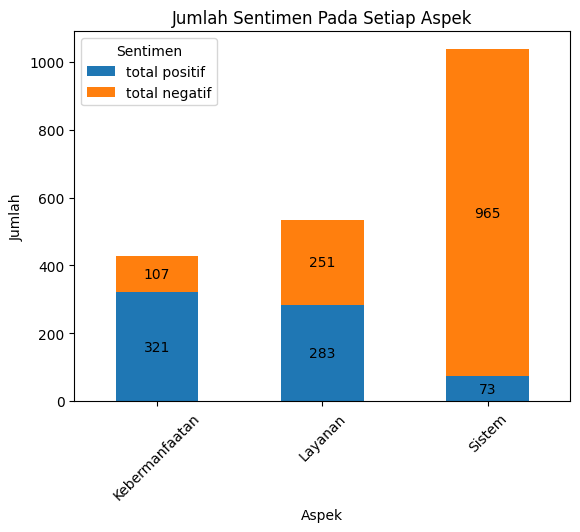

In [4]:
# Mengelompokkan data ulasan berdasarkan aspek dan sentimen
jumlah_aspek_sentimen = df_ulasan.groupby(['Aspek', 'Sentimen']).size().unstack(fill_value=0)

# Menambahkan kolom untuk menghitung total sentimen positif dan negatif
jumlah_aspek_sentimen['total positif'] = jumlah_aspek_sentimen['Positif']
jumlah_aspek_sentimen['total negatif'] = jumlah_aspek_sentimen['Negatif']

# Visualisasi sebaran sentimen dengan angka di tengah
plt.figure(figsize=(10, 6))
ax = jumlah_aspek_sentimen[['total positif', 'total negatif']].plot(kind='bar', stacked=True)
plt.title('Jumlah Sentimen Pada Setiap Aspek')
plt.xlabel('Aspek')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Untuk memutar label sumbu x agar lebih mudah dibaca

# Menambahkan angka di tengah batang
for i, (positif, negatif) in enumerate(zip(jumlah_aspek_sentimen['total positif'], jumlah_aspek_sentimen['total negatif'])):
  ax.text(i, positif / 2, str(positif), ha='center', va='center', fontsize=10)
  ax.text(i, positif + negatif / 2, str(negatif), ha='center', va='center', fontsize=10)

# Meletakkan legenda di bawah xlabel
plt.legend(title='Sentimen', loc='best')
plt.show()

### **Sebaran Sentimen**

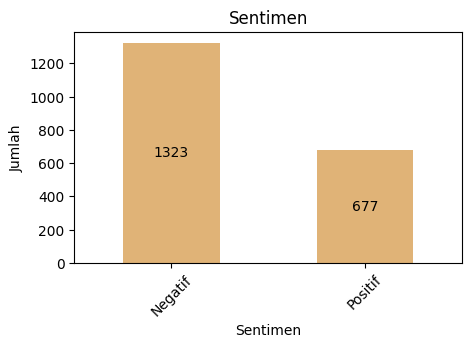

In [5]:
jumlah_sentimen = df_ulasan['Sentimen'].value_counts() # sebaran sentimen

# Warna Hex (misalnya, warna merah)
warna_hex = "#e0b377"

# Visualisasi sebaran sentimen dengan angka di tengah
plt.figure(figsize=(5, 3))
ax = jumlah_sentimen.plot(kind='bar', color=warna_hex)
plt.title('Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Untuk memutar label sumbu x agar lebih mudah dibaca

# Menambahkan angka di tengah batang
for i, v in enumerate(jumlah_sentimen):
    ax.text(i, v / 2, str(v), ha='center', va='center', fontsize=10)

plt.show()

In [6]:
# Memeriksa apakah ada nilai null dalam DataFrame
if df_ulasan.isnull().values.any():
  print("Ada nilai null dalam DataFrame.")
else:
  print("Tidak ada nilai null dalam DataFrame.")

Tidak ada nilai null dalam DataFrame.


## **Text Preprocessing**
***Text Preprocessing*** adalah proses untuk mempersiapkan data teks agar dapat diolah lebih lanjut. Proses ini bertujuan untuk menghilangkan noise dan ketidakteraturan pada data teks, sehingga data tersebut menjadi lebih bersih, terstruktur, dan siap untuk dianalisis. Ada beberapa tahapan dalam text preprocessing, antara lain


1.   ***Case Folding*** : Proses mengubah huruf dalam teks menjadi bentuk seragam, baik itu huruf kecil atau huruf besar. Tujuannya adalah untuk memperlakukan karakter huruf secara konsisten, memudahkan pemrosesan teks, pencocokan string, dan analisis teks
2.   ***Filtering*** : Langkah pra-pemrosesan dalam analisis sentimen yang bertujuan untuk membersihkan teks dari unsur-unsur tidak relevan atau mengganggu. Proses ini mencakup penghapusan tanda baca, URL, karakter khusus, dan emotikon yang tidak berkontribusi pada sentimen. Tujuannya adalah untuk meningkatkan kualitas analisis sentimen dengan mengurangi noise yang dapat mempengaruhi hasil akhir.
3.   ***Stopword Removal*** : Langkah dalam pemrosesan teks untuk menghilangkan kata-kata umum yang tidak memberikan kontribusi signifikan terhadap pemahaman konten. Ini meningkatkan fokus pada kata kunci dan makna penting dalam teks, meningkatkan akurasi dalam analisis sentimen, pengelompokan dokumen, dan ekstraksi informas
4.   ***Stemming*** : Proses mengubah kata-kata menjadi bentuk akarnya untuk mengurangi variasi bentuk kata dengan akar yang sama. Ini membantu analisis teks dengan menyederhanakan variasi kata dan mengurangi dimensi data
5.   ***Tokenizing*** : Proses membagi teks menjadi unit-unit kecil seperti kata, frasa, atau simbol untuk analisis lebih lanjut. Ini penting karena membuat teks mudah diolah dalam tugas pemrosesan bahasa alami

In [7]:
# panjang stopwords sebelum ditambah
len(stopwords_indo)

758

In [8]:
# exclude kata tidak dan membuat
stopwords_indo.remove('tidak')
stopwords_indo.remove('belum')
stopwords_indo.remove('lama')
stopwords_indo.remove('bisa')
stopwords_indo.remove('dapat')
stopwords_indo.remove('membuat')
stopwords_indo.remove('buat')

Pada tahap ini kita perlu menambahkan beberapa list stopword lalu menyimpannya ke dalam variabel stopwords. hal ini dilakukan karena masih terdapat kata-kata yang tidak relevan dalam ulasan tersebut.

In [9]:
# Fungsi menambahkan stopword
def tambahkan_stopword(stopword_baru, stopwords_indo):
  if stopword_baru not in stopwords_indo:
    stopwords_indo.append(stopword_baru)

# list stopword baru
stopwords_baru = ['yah', 'gitu', 'ndak', 'pol', 'jam', 'blom', 'lohhh', 'kemarin', 'hbs', 'mem', 'dkt', 'sy', 'aja', 'jg', 'ama', 'lh', 'tsb', 'abis', 'fi',
                  'alhamdulilah', 'terdepan', 'remang', 'pus', 'wae', 'gtu', 'klaten', 'ginih', 'rs', 'ckckk', 'gtu', 'kantor', 'polseknya', 'laen', 'hr', 
                  'by', 'pusban', 'woi', 'wakanda', 'rumah', 'allooooh', 'ngimbangin', 'kantibmas', 'tlp', 'lu', 'lolosin', 'samperi', 'cetakout', 'smsnya', 
                  'sekaliiii', 'pantesan', 
                  'duper', 'ka', 'sgt', 'cuman', 'msh', 'uda', 'tdk', 'cs', 'gw', 'payah', 'blm', 'ui', 'u', 'mw', 'huhuhu', 'g', 'kyk', 'duit', 'dtg', 'om', 
                  'kunjung', 'jugaa', 'hadehh', 'stuck', 'terkahir', 'muter', 'melulu', 'terkadang', 'lbih', 'ulng', 'memng', 'sumpahhh', 'apaaaa', 'kluar',
                  'bolak', 'capek', 'kocak', 'republik', 'terussss', 'nyampe', 'sensi', 'markotop', 'puyeng', 'dikatain', 'belanda', 'itudapat', 'gtw', 'blanko',
                  'mo', 'nangis', 'satset', 'watwet', 'wess', 'rp', 'palembang', 'smga', 'selvi', 'taudeh', 'tu', 'wajibin', 'rt', 'dj', 'sorry', 'lahh', 'cmn',
                  'allah', 'berulangkali', 'lalu', 'hal', 'aceh', 'orng', 'mantaaap', 'alangkah', 'asem', 'e', 'fc', 'indonesia', 'wow', 'twrus', 'diunintal', 
                  'hadeehhh', 'hadeuh', 'blanj', 'suami', 'gara', 'bulak', 'mauu', 'brapa', 'kapolri', 'selian', 'yng', 'nyampah', 'knpa', 'soreee', 'yak',
                  'positif', 'alhamdullilah', 'gapapa', 'sallam', 'merah', 'putih', 'notabene', 'nyerahin', 'reply', 'kenan', 'rasakan', 'bilamana', 'fikri', 
                  'taopik', 'kurohman', 'bgtt', 'dikit', 'beres', 'bhabin', 'besosialisasi', 'what', 'suda', 'doang', 'sulawesi', 'utara', 'kecamatan', 'singkil',
                  'kelurahan', 'cirebon', 'nie', 'th', 'kec', 'tengaran', 'kab', 'kak', 'kagok', 'zonk', 'ios', 'andro', 'ja', 'jatim', 'ngancar', 'nagncar',
                  'pengen', 'ihhh', 'lngsng', 'npwp', 'ter', 'ginian', 'ai', 'haduhhh', 'fis', 'surabaya', 'international', 'hrs', 'hrsnya', 'bw', 'tk',
                  'lago', 'naa', 'ktnya', 'sidoarjo', 'jni', 'provinsi', 'jombang', 'kesamben', 'wuluh', 'tag', 'blok', 'gimmic', 'setya', 'novanto', 'sigit',
                  'prabowo', 'dsruh', 'bgitu', 'huft', 'sinar', 'pasemah', 'candipuro', 'hadi', 'mustofa', 'adm', 'gresik', 'cimahi', 'cibatat', 'wth', 
                  'manado', 'kota', 'tangerang', 'karawaci', 'medan', 'marah', 'aq', 'disruh', 'bsk', 'leges', 'bkan', 'or', 'notabennya', 'ketua', 'rw', 
                  'pemainlama', 'saranya', 'pergerakan', 'jakarta', 'selatan', 'kroya', 'kabupaten', 'cilacap', 'desa', 'pekuncen', 'kecamatan', 'sidah', 
                  'ramadhan', 'ng', 'ber', 'overall', 'hpku', 'masi', 'tertera', 'hmm', 'bela', 'belain', 'dl', 'terkait', 'beberapakali', 'bacot', 'puluh', 
                  'msih', 'bnyak', 'polda', 'rabu', 'agustus', 'gilran', 'pokonya', 'nkk', 'bri', 'dunk', 'sebel', 'bingungin', 'kn', 'beee', 'dli', 'singga',
                  'september', 'qr', 'kk', 'ama', 'sekar', 'positifjam', 'la', 'sms', 'taugak', 'pakpol', 'malem', 'pagi', 'indonesia', 'sejak', 'hoby', 
                  'wkt', 'lngsung', 'afk', 'mendingan', 'disclamer', 'pd', 'dibilng', 'listyo', 'knp', 'sampek','btal', 'slain', 'ade', 'sisetel', 'kayak', 
                  'genshim', 'impact', 'mncul', 'gimmick', 'sma', 'skali', 'uninstal', 'ngebeleng', 'knp', 'loe', 'orba', 'musti', 'gregetan', 'botak', 'kumis',
                  'berjenggot', 'sii', 'assalamualaikum', 'terlah', 'mei', 'kemayoran', 'bpk', 'kemarena', 'pohon', 'cemara', 'dipucuk', 'sayang', 'daah', 
                  'gt', 'sekian', 'bangeut', 'ktrgn', 'lho', 'kek', 'sdgkn', 'sebenernya', 'degan', 'ta', 'teruss', 'apalahh', 'apasihh', 'selallu', 'wat',
                  'taroh', 'terclose', 'k', 'in', 'embel', 'apaaa', 'ne', 'hadehhh', 'gilir', 'angel', 'na', 'mantaabb', 'gajelas', 'pop', 'superhero', 
                  'tuhan', 'maha', 'esa', 'sndri', 'mesti', 'ubtuk', 'pen', 'yadi', 'utp', 'otpnya', 'krena', 'ttap', 'astagfirullah', 'dg', 'lawak', 
                  'bosan', 'bodoh', 'menit', 'sama', 'emang', 'stag', 'krna', 'tau', 'mngkn', 'ajh', 'eeh', 'kenpa', 'dftr', 'alhamdullillah', 'duongg',
                  'jdinya', 'bgini', 'aduh', 'oke', 'brp', 'mah', 'donkkkk', 'kemana', 'jgan', 'ditanyain', 'berkaitan', 'enakk', 'beuddd', 'yaampunn',
                  'gimna', 'do', 'mlulu', 'mending', 'dslr', 'ush', 'donk', 'setingan', 'belom', 'wkwkwkwkwkw', 'padahall', 'bngt', 'slalu', 'pdahal',
                  'gimanaaa', 'lwt', 'kyak', 'lnjut', 'ha', 'ho', 'kerena', 'lagiii', 'josh', 'ttep', 'padaha', 'pa', 'kemaren', 'subang', 'payahhh',
                  'suksema', 'atp', 'smg', 'akkwkwkw', 'dngn', 'kedepanya', 'muluu', 'beeehh', 'pisan', 'ttg', 'toolong', 'tgl', 'sja', 'sperti', 'wet',
                  'bbrp', 'thd', 'kelas', 'ntah', 'cape', 'dehhh', 'br', 'c', 'mao', 'apasi', 'ampe', 'nihil', 'polres', 'polsek', 'oku', 'timur',
                  'deh', 'makan', 'skrg', 'jga', 'bsa', 'pdhal', 'apain', 'sya', 'gmna', 'jls', 'bet', 'dri', 'ehh', 'nggk', 'dlu', 'jd', 'ny', 'seneng',
                  'selfie', 'hamsong', 'mala', 'ee', 'tetiba', 'kronlogi', 'kalangan', 'sabar', 'onfire', 'trik', 'bnyk', 'ug', 'bangett', 'lalu',
                  'doang', 'minggu', 'sembari', 'sll', 'sm', 'y', 'pk', 'alhamdulillah', 'ajg', 'beda', 'gegara', 'oh', 'iya', "urgent", 'hrus', 'aje', 
                  'nyesal', 'ribetin', 'trnya', 'bermslh', 'astaga', 'hadeh', 'tf', 'byr', 'a', 'serba', 'bls', 'cok', 'lgi', 'mu', 'hri', 'mlah',
                  'anjir', 'masak', 'ajah', 'sumpah', 'eg', 'klo', 'kl', 'pakek', 'sayah', 'wa', 'kayak', 'labih', 'karna', 'memper', 'mlh', 'hal',
                  'nyangkut', 'jalanin', 'opsi', 'sblm', 'nge', 'malam', 'siang', 'mohon', 'gimana', 'dtng', 'untk', 'gmn', 'komandan', 'padahl',
                  'kah', 'hay', 'maret', 'otd', 'tolol', 'wkwk', 'ad', 'mbak', 'ngomel', 'ttl', 'crime', 'klw', 'ksh', 'bego', 'wkkkw', 'negara',
                  'konoha', 'to', 'welcome', 'wkwkwk', 'masyaallah', 'blas', 'buru', 'dlm', 'weee', 'ngulak', 'ngalik', 'sj', 'skli', 'bgtu', 'it', 
                  'hadeeh', 'ehhh', 'emng', 'klau', 'taik', 'diterapin', 'rto', 'd', 'tb','trs', 'haduh', 'ngapain', 'diadain','jlss', 'sush', 'mabes',
                  'sat', 'min', 'klik', 'pngn', 'kaya', 'yg', 'ampun', 'ko', 'dr', 'muantappp', 'tp', 'gua', 'aduhh', 'loading', 'malahn', 'perihal',
                  'mulu', 'bngttt', 'ya', 'dah', 'bravo', 'hp', 'skrng', 'trus', 'dehh', 'kt', 'set', 'loh', 'kntl', 'aj', 'wowwww', 'gais', 'huhh',
                  'gk', 'gin', 'nya', 'nih', 'krn', 'jdi', 'dpt', 'so', 'hehe', 'selaluu', 'gpp', 'koq', 'tuh', 'mulus', 'dll', 'cek','eror', 'byk',
                  'rmh', 'lg', 'sdh', 'udh', 'pke', 'ah', 'bs', 'n', 'sampe', 'dgn', 'utk', 'lgsg', 'mantul', 'si', 'kalo', 'sbl', 'pas', 'bntr', 
                  'kali', 'sih', 'pake', 'tuu', 'gini', 'ok', 'banget', 'opsnal', 'jir', 'lbh', 'ttp', 'dn', 'ku', 'gni', 'michat', 'dikarna',
                  'smoga', 'tpi', 'eh', 'ni', 'udah', 'otp', 'bkin', 'tks', 'via', 'kmrn', 'jgn', 'ri', 'an', 'gue', 'nh', 'biar', 'lo', 'bg', 
                  'no', 'mlu', 'bgt', 'sbg', 'ikd', 'huftt', 'org', 'lgs', 'sore', 'top', 'yuk', 'ngk', 'smpe', 'yaa', 'klu', 'pdhl', 'emg']
#jalankan proses penambahan stopword
for word in stopwords_baru:
  tambahkan_stopword(word, stopwords_indo)

In [10]:
# check apakah ada isi list stopwords_indo yang dobel
from collections import Counter
[k for k,v in Counter(stopwords_indo).items() if v>1]

['sekarang']

In [11]:
class TextPreprocessing:
  def __init__(self):
    pass

  @staticmethod
  def case_folding(text):
    return text.lower()

  @staticmethod
  def ulasan_filtered(text):
    text = re.sub(r'ž|x','',text)
    cleaned_text = ' '.join(word for word in word_tokenize(text) if word.isalpha())
    kata_ganti = {
        "force close": "tutup paksa",
        "dilaunching": "diluncurkan", 
        "ngeload": "memuat", 
        "warning": "peringatan",
        "ruwet": "rumit", 
        "makasih": "terima kasih", 
        "diliatin": "lihat",
        "refund": "pengembalian dana", 
        "ngelayanin": "melayani", 
        "ribetnya": "rumit", 
        "response": "respon", 
        "system": "sistem",
        "gamasuk": "tidak masuk", 
        "apply": "daftar", 
        "ngeblang": "error",
        "ribetkan": "rumit",
        "sdmnya": "sumber daya manusia",
        "gasampe": "tidak sampai", 
        "ngajuin": "mengajukan",
        "balikin": "kembalikan",
        "support": "dukung",
        "clear": "jelas",
        "thank you": "terima kasih",
        "broken": "rusak",
        "tungguin": "tunggu", 
        "customer service": "layanan pelanggan",
        "make": "pakai",
        "entry": "masuk",
        "log in": "masuk",
        "gausah": "tidak perlu",
        "gda": "tidak ada",
        "print": "cetak",
        "okay": "oke",
        "upload": "unggah",
        "gercep": "cepat",
        "laur": "luar",
        "wasting time": "buang buang waktu",
        "bnget": "sekali",
        "selaw": "lambat",
        "poto": "foto",
        "potonya": "fotonya",
        "digunain": "digunakan",
        "pengbilan": "pengambilan",
        "komplit": "lengkap",
        "pokri": "polri",
        "membntu": "membantu",
        "pngaduan": "pengaduan",
        "ribettt": "sulit",
        "gampang": "mudah",
        "dipake": "dipakai",
        "please": "tolong",
        "gabisa": "tidak bisa",
        "trimakasih": "terima kasih",
        "anggarin": "anggarkan",
        "dibenerin": "diperbaiki",
        "benerin": "diperbaiki",
        "feedback": "umpan balik",
        "thankyou": "terima kasih",
        "update": "diperbarui",
        "release": "rilis",
        "install": "pasang",
        "diclose": "di tutup",
        "merefresh": "memuat ulang",
        "dkrim": "dikirim",
        "masukin": "memasukkan",
        "developer": "pengembang",
        "fast": "cepat",
        "cobain": "coba",
        "pending": "tunggu",
        "gagagl": "gagal",
        "dapetin": "dapat",
        "apps": "aplikasi",
        "tdiak": "tidak",
        "gaada": "tidak ada",
        "login": "masuk",
        "brmanfaat": "bermanfaat",
        "acount": "akun",
        "time out": "waktu habis",
        "download": "unduh",
        "lemot": "lambat",
        "lodingnya": "menunggu",
        "loading": "memuat",
        "sending": "mengirim",
        "friendly": "ramah",
        "mgga": "tidak",
        "oktimal": "optimal",
        "fto": "foto",
        "tetep": "tetap",
        "terimakasih": "terima kasih",
        "simple": "simpel",
        "tmpt": "tempat",
        "lalulintas": "lalu lintas",
        "memperibet": "mempersulit",
        "peroses": "proses",
        "expired": "kedaluarsa",
        "ngelamar": "lamar",
        "diinput": "dimasukkan",
        "maintenance": "pemeliharaan",
        "user": "pengguna",
        "ngebug": "cacat",
        "photo": "foto",
        "maksain": "maksa",
        "disalahin": "disalahkan",
        "ngerepotin": "buat rumit",
        "nyusahin": "menyusahkan",
        "thebest": "paling baik",
        "tanggepin": "tanggapi",
        "temenku": "temanku", 
        "blank page": "halaman kosong",
        "helpdesk": "bantuan",
        "logout": "keluar",
        "gaperlu": "tidak perlu",
        "dikembangin": "diperbarui",
        "menginstal": "pasang",
        "dimintain": "minta",
        "duit": "uang",
        "device": "perangkat",
        "the best": "terbaik"
    }
    for kata, ganti in kata_ganti.items():
      if kata in cleaned_text:
        cleaned_text = cleaned_text.replace(kata, ganti)
    return cleaned_text

  @staticmethod
  def remove_stopword(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords_indo]
    return ' '.join(filtered_tokens)

  @staticmethod
  def stemming_ulasan(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    stemmed_words = []
    word_not_stemmed = ["pengalaman","mengatasi","perbaiki","jaringan","tujuan","alasan", "layanan", "mengerti", "kegiatan",
    "perhatikan","anggarkan","pengguna", "acuan","tertera","akui","laksanakan", "kendaraan", "menarik","lingkungan"] # list daftar kata dikecualikan untuk di stemming

    kata_tidak_stem = {
        "pengesahan": "sah",
        "bugnya": "celah",
        "nanya": "tanya",  
        "milih": "pilih",
        "ngelag": "lambat",
        "nunjukkan": "tunjuk", 
        "mencak": "marah",
        "aplikasiny": "aplikasi",
        "respond": "respon",
        "diberitau": "beritahu",
        "application": "aplikasi", 
        "must": "harus",
        "try": "coba", 
        "ijinkan": "ijin",
        "ngabisin": "habis",
        "ngambil": "ambil", 
        "chatnya": "chat",
        "ngecek": "cek", 
        "regis": "registrasi",
        "on": "nyala",
        "ngebantu": "bantu", 
        "konfir": "konfirmasi", 
        "ngulanginya": "ulangi", 
        "onlinenya": "online",
        "ngurusnya": "urus", 
        "layanannya": "layanan",
        "camera": "kamera",
        "meminimalisir": "minimalisir", 
        "dimengerti": "mengerti",
        "apsnya": "aplikasi", 
        "bug": "cacat",
        "direspon": "respon",
        "nggak": "tidak",
        "responnya": "respon",
        "enggak": "tidak",
        "kaga": "kaga",
        "wktu": "waktu",
        "ngak": "tidak",
        "slow": "lambat",
        "mudahin": "mudah",
        "ngulik": "ulik",
        "epired": "kedaluarsa",
        "adminnya": "admin",
        "rekomend": "rekomendasi",
        "rekomen": "rekomendasi",
        "pelayanan": "layanan",
        "benahin": "perbaiki", 
        "dibenahin": "perbaiki",
        "barcodenya": "barcode",
        "rekom": "rekomendasi",
        "notif": "notifikasi",
        "baharu": "baru",
        "merubah": "ubah",
        "apknya": "aplikasi",
        "diverif": "verifikasi",
        "aplikasisnya": "aplikasi",
        "dilingkungan": "lingkungan",
        "ga": "tidak",
        "ngulang": "ulang",
        "ilang": "hilang",
        "tlg": "tolong",
        "nutup": "tutup",
        "loding": "tunggu",
        "verif": "verifikasi",
        "hilangin": "hilang",
        "ngumpulin": "kumpul",
        "kelar": "selesai",
        "ribet": "rumit",
        "fiturnya": "fitur",
        "down": "turun",
        "nyari": "cari",
        "cepet": "cepat",
        "ngurus": "urus",
        "nyoba": "coba", 
        "ngetik": "ketik",
        "pemberitahuan": "tahu",
        "app": "aplikasi",
        "apk": "aplikasi",
        "real": "nyata",
        "liat": "lihat",
        "rumitin": "rumit",
        "nunggu": "tunggu",
        "nungguin": "tunggu",
        "bikin": "buat",
        "non" : "tidak",
        "pengecekan": "cek",
        "semenjak": "sejak",
        "memuaskan": "puas",
        "tujuannya": "tujuan",
        "servernya": "server",
        "ngisi": "isi",
        "perasaan": "rasa",
        "disebarluaskan": "sebar",
        "merespon": "respon",
        "blur": "remang remang",
        "refresh": "segar kembali",
        "diperhatikan": "perhatikan",
        "ngantri": "antri",
        "mengecek": "cek",
        "diperbaiki": "perbaiki",
        "engga": "tidak",
        "ga": "tidak",
        "cameranya": "kamera",
        "ngga": "tidak",
        "bukak": "buka",
        "gak": "tidak",
        "gaa": "tidak",
        "lamaaaa": "lama",
        "full": "penuh",
        "websitenya": "website",
        "mengatasi": "atasi",
        "job": "kerja",
        "low": "lambat",
        "bener": "benar",
        "bnr": "benar",
        "nulis": "tulis",
        "kagak": "tidak",
        "aplikasinya": "aplikasi",
        "verifi": "verifikasi",
        "nga": "tidak",
        "kaga": "tidak",
        "lelet": "lambat",
        "nda": "tidak", 
        "dapet": "dapat",
        "dateng" : "datang",
        "gede": "besar",
        "lampirkan": "lampir",
        "work": "kerja",
        "good": "bagus",
        "recommended": "rekomendasi",
        "pemerintahan": "pemerintah",
        "publish": "publikasi"
    }

    for word in text:
      if word in kata_tidak_stem:
        stemmed_words.append(kata_tidak_stem[word])
      elif word in word_not_stemmed:
        stemmed_words.append(word)
      else:
        stemmed_word = stemmer.stem(word)
        stemmed_words.append(stemmed_word)

    text_stemmed = ' '.join(stemmed_words)
    stemmed_text = word_tokenize(text_stemmed)
    return stemmed_text

  @staticmethod
  def tokenize_ulasan(text):
    tokens = word_tokenize(text)
    return tokens

  @staticmethod
  def preprocessLengkap(text):
    text = TextPreprocessing.case_folding(text)
    text = TextPreprocessing.ulasan_filtered(text)
    text = TextPreprocessing.remove_stopword(text)
    text = TextPreprocessing.tokenize_ulasan(text)
    text = TextPreprocessing.stemming_ulasan(text)
    return text

In [12]:
# buat object dengan nama preprocess
preprocess = TextPreprocessing() # buat object untuk memanggil class TextPreprocessing
df_ulasan.loc[:,'case_folding'] = df_ulasan['Ulasan'].apply(lambda x : preprocess.case_folding(x)) # membuat kolom case_folding
df_ulasan.loc[:,'ulasan_filtered'] = df_ulasan['case_folding'].apply(lambda x: preprocess.ulasan_filtered(x)) # membuat kolom ulasan filtered
df_ulasan.loc[:,'ulasan_stopword'] = df_ulasan['ulasan_filtered'].apply(lambda x: preprocess.remove_stopword(x)) # membuat kolom stopword
df_ulasan.loc[:,'ulasan_tokenized'] = df_ulasan['ulasan_stopword'].apply(lambda x: preprocess.tokenize_ulasan(x)) # membuat kolom tokenized
df_ulasan.loc[:,'ulasan_stemming'] = df_ulasan['ulasan_tokenized'].apply(lambda x : preprocess.stemming_ulasan(x)) # membuat kolom stemming

In [13]:
df_ulasan.head()

,Ulasan,Sentimen,Aspek,case_folding,ulasan_filtered,ulasan_stopword,ulasan_tokenized,ulasan_stemming
0,"Sudah bagus, namun Masih membutuhkan penyempur...",Negatif,Sistem,"sudah bagus, namun masih membutuhkan penyempur...",sudah bagus namun masih membutuhkan penyempurn...,bagus membutuhkan penyempurnaan,"[bagus, membutuhkan, penyempurnaan]","[bagus, butuh, sempurna]"
1,Sangat2x membantu lebih cepet,Positif,Layanan,sangat2x membantu lebih cepet,membantu lebih cepet,membantu cepet,"[membantu, cepet]","[bantu, cepat]"
2,Alhamdulillah sekarang untuk perpanjangan SIM ...,Positif,Layanan,alhamdulillah sekarang untuk perpanjangan sim ...,alhamdulillah sekarang untuk perpanjangan sim ...,perpanjangan sim mudah sistem online tidak rib...,"[perpanjangan, sim, mudah, sistem, online, tid...","[panjang, sim, mudah, sistem, online, tidak, r..."
3,"Verifikasi data, tidak bisa. Sedangkan sinyal ...",Negatif,Sistem,"verifikasi data, tidak bisa. sedangkan sinyal ...",verifikasi data tidak bisa sedangkan sinyal ny...,verifikasi data tidak bisa sinyal bagus verifi...,"[verifikasi, data, tidak, bisa, sinyal, bagus,...","[verifikasi, data, tidak, bisa, sinyal, bagus,..."
4,Tolong di perbaiki lg masak mau daftar harus m...,Negatif,Sistem,tolong di perbaiki lg masak mau daftar harus m...,tolong di perbaiki lg masak mau daftar harus m...,tolong perbaiki daftar mematikan mode pengemba...,"[tolong, perbaiki, daftar, mematikan, mode, pe...","[tolong, perbaiki, daftar, mati, mode, kembang..."


In [14]:
df_ulasan.to_excel("hasil_preprocessing.xlsx",index=False)

In [15]:
columns_to_drop = ['case_folding', 'ulasan_filtered','ulasan_stopword','ulasan_tokenized']
df_ulasan.drop(columns=columns_to_drop, inplace=True)

In [16]:
df_ulasan.head()

,Ulasan,Sentimen,Aspek,ulasan_stemming
0,"Sudah bagus, namun Masih membutuhkan penyempur...",Negatif,Sistem,"[bagus, butuh, sempurna]"
1,Sangat2x membantu lebih cepet,Positif,Layanan,"[bantu, cepat]"
2,Alhamdulillah sekarang untuk perpanjangan SIM ...,Positif,Layanan,"[panjang, sim, mudah, sistem, online, tidak, r..."
3,"Verifikasi data, tidak bisa. Sedangkan sinyal ...",Negatif,Sistem,"[verifikasi, data, tidak, bisa, sinyal, bagus,..."
4,Tolong di perbaiki lg masak mau daftar harus m...,Negatif,Sistem,"[tolong, perbaiki, daftar, mati, mode, kembang..."


## **Training Word2vec**
Word2Vec adalah sebuah teknik pemrosesan bahasa alami (NLP) yang digunakan untuk menghasilkan representasi vektor kata-kata dalam bentuk angka dalam ruang vektor. Representasi ini memungkinkan komputer untuk memahami makna kata-kata berdasarkan konteks mereka dalam teks.
Keunggulan Word2Vec dibandingkan dengan TF-IDF (Term Frequency-Inverse Document Frequency) dan Bag of Words (BoW) adalah sebagai berikut:

1. Konteks Lebih Diperhitungkan: Word2Vec memperhitungkan konteks kata dalam teks, sehingga kata-kata yang muncul bersamaan dalam kalimat yang serupa akan memiliki vektor yang mirip.
2. Representasi Semantik yang Lebih Kaya: Word2Vec menghasilkan representasi vektor kata-kata yang memiliki makna semantik. Ini berarti kata-kata yang sering muncul dalam konteks yang mirip akan memiliki vektor yang mendekati satu sama lain dalam ruang vektor. Sebaliknya, TF-IDF dan BoW hanya menghitung frekuensi kata-kata dalam teks tanpa memperhitungkan makna.

In [17]:
# %%time
model = Word2Vec(df_ulasan['ulasan_stemming'],
                    vector_size=100, #dimensi dari vektor representasi kata
                    window=5, # jarak maksimum antara kata target dan kata konteks
                    min_count=2, # Mengabaikan semua kata dengan frekuensi total di bawah 2.
                    workers=8, # jumlah thread
                    epochs=1000, #jumlah iterasi
                    sg=1) # 1 untuk skip-gram model
model.save('ulasan_fix.w2v')

## **Load Pretrained Word2Vec**
beberapa atribut yang ada pada dokumentasi gensim word2vec : [klik](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)

In [18]:
# load word2vec pretrained model
w2v_model = Word2Vec.load('ulasan_fix.w2v')

In [19]:
# buat object
model = w2v_model.wv

In [20]:
len(model)

703

In [21]:
model.vectors

array([[-0.0851151 , -0.02633026,  0.16664885, ..., -0.2597925 ,
        -0.21814351,  0.00686368],
       [-0.21095015,  0.36031193,  0.125352  , ..., -0.11636142,
        -0.09754462,  0.14565445],
       [ 0.29791418,  0.21185893, -0.30285734, ..., -0.09255001,
        -0.31607828,  0.02051081],
       ...,
       [-0.30988526,  0.35053074, -0.34945875, ..., -0.2571114 ,
        -0.5145159 , -0.09080226],
       [-0.3756971 ,  0.655378  ,  0.15904173, ..., -0.28382933,
        -0.14482112, -0.44362903],
       [-0.425754  ,  0.01964489,  0.10291579, ..., -0.5706393 ,
        -0.19530536,  0.32445747]], dtype=float32)

In [22]:
model.key_to_index["verifikasi"]

3

In [23]:
# Build dictionary from word to index
word_to_index = {word: index for index, word in enumerate(model.index_to_key)}
word_to_index

{'aplikasi': 0,
 'tidak': 1,
 'bisa': 2,
 'verifikasi': 3,
 'buat': 4,
 'skck': 5,
 'data': 6,
 'mudah': 7,
 'bantu': 8,
 'online': 9,
 'lama': 10,
 'daftar': 11,
 'perbaiki': 12,
 'foto': 13,
 'tolong': 14,
 'sulit': 15,
 'masyarakat': 16,
 'panjang': 17,
 'susah': 18,
 'bagus': 19,
 'belum': 20,
 'sim': 21,
 'urus': 22,
 'tunggu': 23,
 'layanan': 24,
 'isi': 25,
 'ktp': 26,
 'masuk': 27,
 'cepat': 28,
 'polri': 29,
 'kasih': 30,
 'rumit': 31,
 'muat': 32,
 'proses': 33,
 'coba': 34,
 'gagal': 35,
 'bayar': 36,
 'polisi': 37,
 'terima': 38,
 'kode': 39,
 'lengkap': 40,
 'lambat': 41,
 'kirim': 42,
 'cacat': 43,
 'kamera': 44,
 'fitur': 45,
 'sesuai': 46,
 'identitas': 47,
 'pakai': 48,
 'butuh': 49,
 'ulang': 50,
 'ambil': 51,
 'muncul': 52,
 'respon': 53,
 'moga': 54,
 'buka': 55,
 'guna': 56,
 'baru': 57,
 'informasi': 58,
 'akun': 59,
 'suruh': 60,
 'tingkat': 61,
 'manfaat': 62,
 'email': 63,
 'kerja': 64,
 'jaringan': 65,
 'lapor': 66,
 'langsung': 67,
 'mantap': 68,
 'sistem': 6

In [24]:
# check word vector dari tiap kata
model["verifikasi"]

array([-0.1270076 ,  0.6056059 ,  0.08278303, -0.40279052,  0.3229098 ,
       -0.50775313,  0.14855129,  0.22301966,  0.09372812, -0.17604277,
        0.1924152 , -0.11844064, -0.5150925 ,  0.07128419,  0.06840493,
       -0.06630175,  0.12030441, -0.12638225, -0.16845408,  0.2262334 ,
        0.03950979, -0.20112257,  0.34663656, -0.00207278, -0.0047871 ,
       -0.16730665, -0.3343724 , -0.14050189,  0.03426204,  0.1262914 ,
       -0.0698913 , -0.15739338,  0.13761021, -0.38107678, -0.03118085,
       -0.05969125, -0.39005283,  0.01646499, -0.27684093, -0.1355274 ,
        0.22595705,  0.10272887,  0.0217492 ,  0.23596628,  0.0285351 ,
       -0.27520293, -0.19158678, -0.01781207, -0.21482602, -0.10127997,
       -0.03862224, -0.1213052 , -0.3267938 , -0.08353592,  0.03128807,
        0.19903705,  0.11792064,  0.10897242,  0.15638502,  0.0860706 ,
       -0.27452984, -0.07837328,  0.02435432,  0.2640673 , -0.13961609,
        0.10562962,  0.21799305, -0.11812337, -0.2232188 , -0.47

In [25]:
# Gantilah 'kata_tujuan' dengan kata yang ingin Anda cari yang mirip
kata_tujuan = 'bagus'
kata_mirip = model.most_similar(kata_tujuan, topn=5)

# Tampilkan kata-kata yang mirip
for kata, similaritas in kata_mirip:
    print(f'Kata: {kata}, Similaritas: {similaritas}')

Kata: jaya, Similaritas: 0.3196572959423065
Kata: nonaktif, Similaritas: 0.30334293842315674
Kata: kacau, Similaritas: 0.2953853905200958
Kata: sentuh, Similaritas: 0.2877221703529358
Kata: gila, Similaritas: 0.2803722023963928


## **Pembuatan Fitur**
Penghitungan rata-rata vektor ini mengubah teks menjadi representasi vektor tunggal yang mencerminkan makna atau konteks dari seluruh teks. Dalam konteks analisis sentimen, ini membantu dalam mengekspresikan sentimen keseluruhan dari teks tersebut.

Alasan mengapa kita menghitung rata-rata vektor dari kata-kata dalam teks adalah untuk menghasilkan representasi yang lebih kompak dari keseluruhan teks. Setiap kata dalam teks dipetakan ke dalam ruang vektor dengan model Word2Vec, dan dengan mengambil rata-rata vektor-vektor kata tersebut, kita dapat memiliki representasi vektor tunggal yang mencerminkan makna atau konteks dari seluruh teks.

Ini bermanfaat dalam kasus analisis sentimen karena kita ingin mengukur sentimen keseluruhan dari suatu ulasan atau teks, bukan hanya sentimen dari setiap kata secara terpisah. Dengan kata lain, kita ingin mengekspresikan apakah keseluruhan teks tersebut memiliki sentimen positif, atau negatif.

In [26]:
def calculate_average_vector(text, model):
  average_vector = np.zeros(model.vector_size) # Menginisialisasi vektor rata-rata dengan nol
  valid_word_count = 0 # Menghitung jumlah kata yang ada dalam model Word2Vec
  for word in text:
    if word in model:
      average_vector += model[word]
      valid_word_count += 1
  if valid_word_count > 0:
    average_vector /= valid_word_count # Membagi vektor rata-rata dengan jumlah kata yang valid
  return average_vector

In [27]:
df_ulasan['text_vector'] = df_ulasan['ulasan_stemming'].apply(lambda x: calculate_average_vector(x, model))

In [28]:
df_ulasan.head()

,Ulasan,Sentimen,Aspek,ulasan_stemming,text_vector
0,"Sudah bagus, namun Masih membutuhkan penyempur...",Negatif,Sistem,"[bagus, butuh, sempurna]","[0.12964070091644922, 0.2031408486266931, 0.29..."
1,Sangat2x membantu lebih cepet,Positif,Layanan,"[bantu, cepat]","[0.04974478483200073, 0.10488614439964294, -0...."
2,Alhamdulillah sekarang untuk perpanjangan SIM ...,Positif,Layanan,"[panjang, sim, mudah, sistem, online, tidak, r...","[0.0050252380801144424, 0.17883772176823445, 0..."
3,"Verifikasi data, tidak bisa. Sedangkan sinyal ...",Negatif,Sistem,"[verifikasi, data, tidak, bisa, sinyal, bagus,...","[-0.014322250253624387, 0.4989841911527846, 0...."
4,Tolong di perbaiki lg masak mau daftar harus m...,Negatif,Sistem,"[tolong, perbaiki, daftar, mati, mode, kembang...","[0.0662685502320528, -0.053573133423924446, 0...."


In [29]:
df_ulasan.to_excel('ulasan_vector.xlsx', index = False)

## **Pembuatan Label**
Algoritma pembelajaran mesin, seperti SVM, bekerja dengan perhitungan matematis pada data. Oleh karena itu, mereka memerlukan input yang bersifat numerik atau dapat dihitung. Kategori atau label dalam bentuk teks atau string tidak dapat digunakan secara langsung dalam perhitungan matematis. Oleh karena itu, encoding adalah proses mengubah kategori atau label ini menjadi representasi numerik.

In [30]:
# Encodes positive labels to 1 and negative labels to -1
df_ulasan['Sentimen'] = df_ulasan['Sentimen'].apply(lambda x: 1 if x == 'Positif' else -1)

# Encodes each aspect in column aspect
aspek_mapping = {"Layanan": 0, "Sistem": 1, "Kebermanfaatan": 2}
df_ulasan['Aspek'] = df_ulasan['Aspek'].apply(lambda x: aspek_mapping.get(x))

In [31]:
df_ulasan.head()

,Ulasan,Sentimen,Aspek,ulasan_stemming,text_vector
0,"Sudah bagus, namun Masih membutuhkan penyempur...",-1,1,"[bagus, butuh, sempurna]","[0.12964070091644922, 0.2031408486266931, 0.29..."
1,Sangat2x membantu lebih cepet,1,0,"[bantu, cepat]","[0.04974478483200073, 0.10488614439964294, -0...."
2,Alhamdulillah sekarang untuk perpanjangan SIM ...,1,0,"[panjang, sim, mudah, sistem, online, tidak, r...","[0.0050252380801144424, 0.17883772176823445, 0..."
3,"Verifikasi data, tidak bisa. Sedangkan sinyal ...",-1,1,"[verifikasi, data, tidak, bisa, sinyal, bagus,...","[-0.014322250253624387, 0.4989841911527846, 0...."
4,Tolong di perbaiki lg masak mau daftar harus m...,-1,1,"[tolong, perbaiki, daftar, mati, mode, kembang...","[0.0662685502320528, -0.053573133423924446, 0...."


## **Pengujian Model**

### **Proporsi Data**

#### **Pengujian Sentimen**

In [32]:
X = np.vstack(df_ulasan['text_vector'])
y_sentimen = df_ulasan["Sentimen"]

# Definisikan proporsi data latih
train_sizes = [0.6, 0.7, 0.8, 0.9]

# Membuat lists untuk menyimpan hasil
proporsi_data = []
akurasi_sentimen = []
precision_sentimen = []
recall_sentimen = []
f1_score_sentimen = []

# Loop untuk mencoba berbagai proporsi
for train_size in train_sizes:
    test_size = 1 - train_size
    # Bagi data menjadi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(X, y_sentimen, test_size=test_size, random_state=42, shuffle=True)

    # Inisialisasi model SVM
    clf = SVC(kernel='linear')

    # Melatih model dengan data latih
    clf.fit(X_train, y_train)

    # Memprediksi data uji
    y_pred = clf.predict(X_test)

    # Menghitung metrik-metrik Sentimen
    classification_result = classification_report(y_test, y_pred, output_dict=True)
    
    # Menyimpan hasil
    akurasi_sentimen.append(classification_result['accuracy'] * 100)
    precision_sentimen.append(classification_result['weighted avg']['precision'] * 100)
    recall_sentimen.append(classification_result['weighted avg']['recall'] * 100)
    f1_score_sentimen.append(classification_result['weighted avg']['f1-score'] * 100)

# Membuat DataFrame dari hasil Sentimen
results_sentimen = pd.DataFrame({
    'Proporsi Data': ['60:40', '70:30', '80:20', '90:10'],
    'Accuracy': akurasi_sentimen,
    'Precision': precision_sentimen,
    'Recall': recall_sentimen,
    'F1-Score': f1_score_sentimen
})
print("=========== Hasil Pengujian Proporsi Data Sentimen ===========")
results_sentimen

=========== Hasil Pengujian Proporsi Data Sentimen ===========


,Proporsi Data,Accuracy,Precision,Recall,F1-Score
0,60:40,95.000000,95.010661,95.000000,95.004673
1,70:30,95.507488,95.496985,95.507488,95.499611
2,80:20,96.250000,96.258077,96.250000,96.253374
3,90:10,96.000000,96.161279,96.000000,96.036797


#### **Pengujian Aspek**

In [33]:
X = np.vstack(df_ulasan['text_vector'])
y_aspect = df_ulasan["Aspek"]

# Membuat lists untuk menyimpan hasil
proporsi_data = []
akurasi_aspect = []
precision_aspect = []
recall_aspect = []
f1_score_aspect = []

# Proporsi data latih dan data uji yang ingin diuji
proporsi_data_uji = [0.3, 0.3, 0.2, 0.1]
proporsi_data_latih = [1 - proporsi for proporsi in proporsi_data_uji]

# Loop untuk mencoba berbagai proporsi
for train_size, test_size in zip(proporsi_data_latih, proporsi_data_uji):
    # Bagi data menjadi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(X, y_aspect, test_size=test_size, random_state=42, shuffle=True)

    # Inisialisasi model SVM
    clf = SVC(kernel='linear')

    # Melatih model dengan data latih
    clf.fit(X_train, y_train)

    # Memprediksi data uji
    y_pred = clf.predict(X_test)

    # Menghitung metrik-metrik Aspek
    classification_result = classification_report(y_test, y_pred, output_dict=True)
    
    # Menyimpan hasil
    akurasi_aspect.append(classification_result['accuracy'] * 100)
    precision_aspect.append(classification_result['weighted avg']['precision'] * 100)
    recall_aspect.append(classification_result['weighted avg']['recall'] * 100)
    f1_score_aspect.append(classification_result['weighted avg']['f1-score'] * 100)

# Membuat DataFrame dari hasil Aspek
results_aspect = pd.DataFrame({
    'Proporsi Data': ['60:40', '70:30', '80:20', '90:10'],
    'Accuracy': akurasi_aspect,
    'Precision': precision_aspect,
    'Recall': recall_aspect,
    'F1-Score': f1_score_aspect
})
print("=========== Hasil Pengujian Proporsi Data Aspek ===========")
results_aspect

=========== Hasil Pengujian Proporsi Data Aspek ===========


,Proporsi Data,Accuracy,Precision,Recall,F1-Score
0,60:40,78.0,78.020350,78.0,77.666504
1,70:30,78.0,78.020350,78.0,77.666504
2,80:20,77.5,77.560305,77.5,76.996321
3,90:10,78.5,78.453739,78.5,77.793787


### **Hyperparameter**

In [34]:
# Data Anda
X = np.vstack(df_ulasan['text_vector'])
y_aspek = df_ulasan["Aspek"]
y_sentimen = df_ulasan["Sentimen"]

# Daftar nilai C, jenis kernel, dan gamma yang ingin diuji
C_values = [0.1, 1, 10]
kernels = ['linear', 'rbf', 'poly']
gamma_values = [0.01, 0.1, 1]

# Inisialisasi DataFrame untuk menyimpan hasil
results_df = pd.DataFrame(columns=['Kernel', 'C', 'Gamma', 'Accuracy Aspek', 'Accuracy Sentimen'])

# Loop melalui kombinasi hyperparameter
for kernel in kernels:
    for C in C_values:
        for gamma in gamma_values:
            svm_aspek = SVC(kernel=kernel, C=C, gamma=gamma)
            scores_aspek = cross_val_score(svm_aspek, X, y_aspek, cv=5)
            mean_accuracy_aspek = scores_aspek.mean()
            
            svm_sentimen = SVC(kernel=kernel, C=C, gamma=gamma)
            scores_sentimen = cross_val_score(svm_sentimen, X, y_sentimen, cv=5)
            mean_accuracy_sentimen = scores_sentimen.mean()
            
            results_df.loc[len(results_df)] = [kernel, C, gamma, mean_accuracy_aspek, mean_accuracy_sentimen]

# Menampilkan dataframe hasil akurasi
print("========Hyperparameter Aspek, Sentimen, dan Gamma=======")
results_df

========Hyperparameter Aspek, Sentimen, dan Gamma=======


,Kernel,C,Gamma,Accuracy Aspek,Accuracy Sentimen
0,linear,0.1,0.01,0.7375,0.9495
1,linear,0.1,0.10,0.7375,0.9495
2,linear,0.1,1.00,0.7375,0.9495
3,linear,1.0,0.01,0.7445,0.9475
4,linear,1.0,0.10,0.7445,0.9475
5,linear,1.0,1.00,0.7445,0.9475
6,linear,10.0,0.01,0.7320,0.9420
7,linear,10.0,0.10,0.7320,0.9420
8,linear,10.0,1.00,0.7320,0.9420
9,rbf,0.1,0.01,0.5190,0.7965


In [35]:
results_df.to_excel("hasil hyperparameter.xlsx", index=False)

In [36]:
# Menemukan indeks baris dengan akurasi tertinggi untuk Aspek
best_aspek_row = results_df.loc[results_df['Accuracy Aspek'].idxmax()]

# Menemukan indeks baris dengan akurasi tertinggi untuk Sentimen
best_sentimen_row = results_df.loc[results_df['Accuracy Sentimen'].idxmax()]

# Mencetak hasil
print("========Hasil Terbaik untuk Aspek=======")
print(f"Kernel: {best_aspek_row['Kernel']}, C: {best_aspek_row['C']}, Gamma: {best_aspek_row['Gamma']}")
print(f"Akurasi Aspek: {best_aspek_row['Accuracy Aspek']}")

print("\n========Hasil Terbaik untuk Sentimen=======")
print(f"Kernel: {best_sentimen_row['Kernel']}, C: {best_sentimen_row['C']}, Gamma: {best_sentimen_row['Gamma']}")
print(f"Akurasi Sentimen: {best_sentimen_row['Accuracy Sentimen']}")

========Hasil Terbaik untuk Aspek=======
Kernel: rbf, C: 10.0, Gamma: 0.1
Akurasi Aspek: 0.7585

========Hasil Terbaik untuk Sentimen=======
Kernel: poly, C: 10.0, Gamma: 0.1
Akurasi Sentimen: 0.9535


### **K Fold Cross Validation**
Tujuan melakukan pengujian nilai K pada cross-validation adalah untuk menemukan nilai K yang optimal untuk model Anda. Cross-validation adalah teknik yang digunakan untuk mengukur kinerja model dalam melakukan generalisasi terhadap data yang belum pernah dilihat sebelumnya. Nilai K dalam cross-validation mengacu pada jumlah lipatan atau "folds" yang digunakan dalam proses pengujian. Dengan mencoba beberapa nilai K yang berbeda, Anda dapat mengevaluasi bagaimana model Anda berperilaku dalam berbagai skenario pembagian data.

Pemilihan nilai K yang optimal dapat membantu Anda mendapatkan perkiraan yang lebih baik tentang kinerja model Anda. Jika K terlalu kecil, mungkin ada overfitting karena model hanya dievaluasi pada sebagian kecil data. Sebaliknya, jika K terlalu besar, Anda mungkin kehilangan beberapa informasi penting dan akurasi mungkin menurun. Oleh karena itu, melakukan eksperimen dengan berbagai nilai K pada cross-validation membantu Anda menemukan keseimbangan yang baik antara varians dan bias dalam model Anda.

In [37]:
# Membuat DataFrame untuk menyimpan hasil
results_df = pd.DataFrame(columns=["K", "Fold", "Accuracy (Aspect)", "Accuracy (Sentiment)"])

# Menggabungkan dataframe atau df_ulasan
X = np.vstack(df_ulasan['text_vector'])
y_aspect = df_ulasan['Aspek']
y_sentiment = df_ulasan['Sentimen']

# Daftar nilai K yang akan diuji
k_values = [3, 5, 7, 10]

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_num = 0

    for train_index, test_index in kf.split(X):
        fold_num += 1
        X_train, X_test = X[train_index], X[test_index]
        y_aspect_train, y_aspect_test = y_aspect[train_index], y_aspect[test_index]
        y_sentiment_train, y_sentiment_test = y_sentiment[train_index], y_sentiment[test_index]

        # Langkah 7: Pembuatan Model SVM untuk Aspek
        svm_aspect = SVC(C=1, kernel='rbf', gamma=0.1)
        svm_aspect.fit(X_train, y_aspect_train)

        # Langkah 7: Pembuatan Model SVM untuk Sentimen
        svm_sentiment = SVC(C=10, kernel='poly', gamma=0.1)
        svm_sentiment.fit(X_train, y_sentiment_train)

        # Langkah 8: Evaluasi Model (Aspek dan Sentimen)
        y_aspect_pred = svm_aspect.predict(X_test)
        y_sentiment_pred = svm_sentiment.predict(X_test)

        # Hitung akurasi
        accuracy_aspect = accuracy_score(y_aspect_test, y_aspect_pred)
        accuracy_sentiment = accuracy_score(y_sentiment_test, y_sentiment_pred)

        # Menyimpan hasil ke dalam DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            "K": [k],
            "Fold": [fold_num],
            "Accuracy (Aspect)": [accuracy_aspect],
            "Accuracy (Sentiment)": [accuracy_sentiment]
        })], ignore_index=True)

# Tampilkan DataFrame hasil
results_df

C:\Users\USER\AppData\Local\Temp\ipykernel_18712\48366683.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


,K,Fold,Accuracy (Aspect),Accuracy (Sentiment)
0,3,1,0.754123,0.953523
1,3,2,0.715142,0.943028
2,3,3,0.741742,0.959459
3,5,1,0.767500,0.962500
4,5,2,0.742500,0.947500
5,5,3,0.727500,0.947500
6,5,4,0.762500,0.957500
7,5,5,0.742500,0.957500
8,7,1,0.783217,0.965035
9,7,2,0.751748,0.951049


In [38]:
results_df.to_excel("hasil_cv.xlsx", index=False)

## **SMOTE**

### **Proporsi Data**

#### **Pengujian Sentimen SMOTE** ####

In [39]:
# Fungsi untuk mengaplikasikan SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

# Membuat lists untuk menyimpan hasil
proporsi_data = [0.6, 0.7, 0.8, 0.9]
akurasi_sentimen = []
precision_sentimen = []
recall_sentimen = []
f1_score_sentimen = []

# Loop untuk mencoba berbagai proporsi
for proporsi in proporsi_data:
    test_size = 1 - proporsi
    # Bagi data menjadi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(X, y_sentimen, test_size=test_size, random_state=42, shuffle=True)

    # Aplikasikan SMOTE hanya pada data latih
    X_train_smote, y_train_smote = apply_smote(X_train, y_train)

    # Inisialisasi model SVM
    clf = SVC(kernel='linear')

    # Melatih model dengan data latih yang telah di-SMOTE
    clf.fit(X_train_smote, y_train_smote)

    # Memprediksi data uji
    y_pred = clf.predict(X_test)

    # Menghitung metrik-metrik Sentimen
    classification_result = classification_report(y_test, y_pred, output_dict=True)
    
    # Menyimpan hasil
    akurasi_sentimen.append(classification_result['accuracy'] * 100)
    precision_sentimen.append(classification_result['weighted avg']['precision'] * 100)
    recall_sentimen.append(classification_result['weighted avg']['recall'] * 100)
    f1_score_sentimen.append(classification_result['weighted avg']['f1-score'] * 100)

# Membuat DataFrame dari hasil Sentimen
results_sentimen = pd.DataFrame({
    'Proporsi Data': ['60:40', '70:30', '80:20', '90:10'],
    'Accuracy': akurasi_sentimen,
    'Precision': precision_sentimen,
    'Recall': recall_sentimen,
    'F1-Score': f1_score_sentimen
})
print("===== Hasil Pengujian Proporsi Data Sentimen dengan SMOTE =====")
results_sentimen

===== Hasil Pengujian Proporsi Data Sentimen dengan SMOTE =====


,Proporsi Data,Accuracy,Precision,Recall,F1-Score
0,60:40,95.625000,95.687143,95.625000,95.642800
1,70:30,95.008319,95.061810,95.008319,95.024825
2,80:20,96.000000,96.048954,96.000000,96.013988
3,90:10,95.000000,95.324786,95.000000,95.066620


#### **Pengujian Aspek SMOTE** ####

In [40]:
# Fungsi untuk mengaplikasikan SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

# Menentukan proporsi data untuk diuji
proporsi_data = [0.6, 0.7, 0.8, 0.9]

# Membuat lists untuk menyimpan hasil
akurasi_aspect = []
precision_aspect = []
recall_aspect = []
f1_score_aspect = []

# Loop untuk mencoba berbagai proporsi
for proporsi in proporsi_data:
    # Bagi data menjadi data latih dan data uji
    test_size = 1 - proporsi
    X_train, X_test, y_train, y_test = train_test_split(X, y_aspect, test_size=test_size, random_state=42, shuffle=True)

    # Aplikasikan SMOTE hanya pada data latih
    X_train_smote, y_train_smote = apply_smote(X_train, y_train)

    # Inisialisasi model SVM
    clf = SVC(kernel='linear')

    # Melatih model dengan data latih yang telah di-SMOTE
    clf.fit(X_train_smote, y_train_smote)

    # Memprediksi data uji
    y_pred = clf.predict(X_test)

    # Menghitung metrik-metrik Aspek
    classification_result = classification_report(y_test, y_pred, output_dict=True)
    
    # Menyimpan hasil
    akurasi_aspect.append(classification_result['accuracy'] * 100)
    precision_aspect.append(classification_result['weighted avg']['precision'] * 100)
    recall_aspect.append(classification_result['weighted avg']['recall'] * 100)
    f1_score_aspect.append(classification_result['weighted avg']['f1-score'] * 100)

# Membuat DataFrame dari hasil Aspek
results_aspect_smote = pd.DataFrame({
    'Proporsi Data': ['60:40', '70:30', '80:20', '90:10'],
    'Accuracy': akurasi_aspect,
    'Precision': precision_aspect,
    'Recall': recall_aspect,
    'F1-Score': f1_score_aspect
})
print("===== Hasil Pengujian Proporsi Data Aspek dengan SMOTE =====")
results_aspect_smote

===== Hasil Pengujian Proporsi Data Aspek dengan SMOTE =====


,Proporsi Data,Accuracy,Precision,Recall,F1-Score
0,60:40,73.625000,74.016396,73.625000,73.774278
1,70:30,73.710483,74.378749,73.710483,73.940900
2,80:20,75.250000,75.797882,75.250000,75.430276
3,90:10,81.500000,81.573020,81.500000,81.456759


### **Hyperparameter**

In [41]:
# Data Anda
X = np.vstack(df_ulasan['text_vector'])
y_aspek = df_ulasan["Aspek"]
y_sentimen = df_ulasan["Sentimen"]

# Daftar nilai C, gamma, dan jenis kernel yang ingin diuji
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']

# Inisialisasi DataFrame untuk menyimpan hasil
results_df = pd.DataFrame(columns=['Kernel', 'C', 'Gamma', 'Accuracy Aspek', 'Accuracy Sentimen'])

# Loop melalui kombinasi hyperparameter
for kernel in kernels:
    for C in C_values:
        for gamma in gamma_values:
            # Inisialisasi SMOTE
            smote = SMOTE(random_state=42)

            # Menerapkan SMOTE pada data latih untuk aspek
            X_resampled_aspek, y_resampled_aspek = smote.fit_resample(X, y_aspek)

            svm_aspek = SVC(kernel=kernel, C=C, gamma=gamma)
            scores_aspek = cross_val_score(svm_aspek, X_resampled_aspek, y_resampled_aspek, cv=5)
            mean_accuracy_aspek = scores_aspek.mean()
            
            # Menerapkan SMOTE pada data latih untuk sentimen
            X_resampled_sentimen, y_resampled_sentimen = smote.fit_resample(X, y_sentimen)

            svm_sentimen = SVC(kernel=kernel, C=C, gamma=gamma)
            scores_sentimen = cross_val_score(svm_sentimen, X_resampled_sentimen, y_resampled_sentimen, cv=5)
            mean_accuracy_sentimen = scores_sentimen.mean()
            
            results_df.loc[len(results_df)] = [kernel, C, gamma, mean_accuracy_aspek, mean_accuracy_sentimen]

# Menampilkan dataframe hasil akurasi
print("========Hyperparameter Aspek dan Sentimen dengan SMOTE=======")
results_df

========Hyperparameter Aspek dan Sentimen dengan SMOTE=======


,Kernel,C,Gamma,Accuracy Aspek,Accuracy Sentimen
0,linear,0.1,0.01,0.751772,0.953136
1,linear,0.1,0.10,0.751772,0.953136
2,linear,0.1,1.00,0.751772,0.953136
3,linear,1.0,0.01,0.766866,0.951622
4,linear,1.0,0.10,0.766866,0.951622
5,linear,1.0,1.00,0.766866,0.951622
6,linear,10.0,0.01,0.765582,0.952006
7,linear,10.0,0.10,0.765582,0.952006
8,linear,10.0,1.00,0.765582,0.952006
9,rbf,0.1,0.01,0.652211,0.950491


In [42]:
results_df.to_excel("hasil hyperparameter(smote).xlsx", index=False)

In [43]:
# Menemukan indeks baris dengan akurasi tertinggi untuk Aspek
best_aspek_row = results_df.loc[results_df['Accuracy Aspek'].idxmax()]

# Menemukan indeks baris dengan akurasi tertinggi untuk Sentimen
best_sentimen_row = results_df.loc[results_df['Accuracy Sentimen'].idxmax()]

# Mencetak hasil
print("========Hasil Terbaik untuk Aspek (SMOTE)=======")
print(f"Kernel: {best_aspek_row['Kernel']}, C: {best_aspek_row['C']}, Gamma: {best_aspek_row['Gamma']}")
print(f"Akurasi Aspek: {best_aspek_row['Accuracy Aspek']}")

print("\n========Hasil Terbaik untuk Sentimen (SMOTE)=======")
print(f"Kernel: {best_sentimen_row['Kernel']}, C: {best_sentimen_row['C']}, Gamma: {best_sentimen_row['Gamma']}")
print(f"Akurasi Sentimen: {best_sentimen_row['Accuracy Sentimen']}")

========Hasil Terbaik untuk Aspek (SMOTE)=======
Kernel: rbf, C: 10.0, Gamma: 1.0
Akurasi Aspek: 0.8747828420721226

========Hasil Terbaik untuk Sentimen (SMOTE)=======
Kernel: poly, C: 0.1, Gamma: 1.0
Akurasi Sentimen: 0.9625880087027856


### **K Fold Cross Validation**

In [44]:
# Membuat DataFrame untuk menyimpan hasil
results_df = pd.DataFrame(columns=["K", "Fold", "Accuracy (Aspect)", "Accuracy (Sentiment)"])

# Menggabungkan dataframe atau df_ulasan
X = np.vstack(df_ulasan['text_vector'])
y_aspect = df_ulasan['Aspek']
y_sentiment = df_ulasan['Sentimen']

# Daftar nilai K yang akan diuji
k_values = [3, 5, 7, 10]

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_num = 0

    for train_index, test_index in kf.split(X):
        fold_num += 1
        X_train, X_test = X[train_index], X[test_index]
        y_aspect_train, y_aspect_test = y_aspect[train_index], y_aspect[test_index]
        y_sentiment_train, y_sentiment_test = y_sentiment[train_index], y_sentiment[test_index]

        # Langkah 6a: Oversampling dengan SMOTE pada data latih untuk Aspek
        smote_aspect = SMOTE(random_state=42)
        X_train_resampled_aspect, y_aspect_train_resampled = smote_aspect.fit_resample(X_train, y_aspect_train)

        # Langkah 6b: Oversampling dengan SMOTE pada data latih untuk Sentimen
        smote_sentiment = SMOTE(random_state=42)
        X_train_resampled_sentiment, y_sentiment_train_resampled = smote_sentiment.fit_resample(X_train, y_sentiment_train)

        # Langkah 7: Pembuatan Model SVM untuk Aspek
        svm_aspect = SVC(C=10, kernel='rbf', gamma=1)
        svm_aspect.fit(X_train_resampled_aspect, y_aspect_train_resampled)

        # Langkah 8: Evaluasi Model Aspek
        y_aspect_pred = svm_aspect.predict(X_test)
        accuracy_aspect = accuracy_score(y_aspect_test, y_aspect_pred)

        # Langkah 9: Pembuatan Model SVM untuk Sentimen
        svm_sentiment = SVC(C=0.1, kernel='poly', gamma=1)
        svm_sentiment.fit(X_train_resampled_sentiment, y_sentiment_train_resampled)

        # Langkah 10: Evaluasi Model Sentimen
        y_sentiment_pred = svm_sentiment.predict(X_test)
        accuracy_sentiment = accuracy_score(y_sentiment_test, y_sentiment_pred)

        # Menyimpan hasil ke dalam DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            "K": [k],
            "Fold": [fold_num],
            "Accuracy (Aspect)": [accuracy_aspect],
            "Accuracy (Sentiment)": [accuracy_sentiment]
        })], ignore_index=True)

# Tampilkan DataFrame hasil
results_df

C:\Users\USER\AppData\Local\Temp\ipykernel_18712\2245629855.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


,K,Fold,Accuracy (Aspect),Accuracy (Sentiment)
0,3,1,0.680660,0.938531
1,3,2,0.673163,0.941529
2,3,3,0.680180,0.944444
3,5,1,0.662500,0.942500
4,5,2,0.700000,0.935000
5,5,3,0.652500,0.932500
6,5,4,0.722500,0.937500
7,5,5,0.690000,0.945000
8,7,1,0.727273,0.951049
9,7,2,0.681818,0.926573


In [45]:
# results_df.to_excel("hasil_cv (SMOTE).xlsx",index=False)

## **Save SVM Model**

In [46]:
# Simpan model SVM Aspek
with open('model_svm_aspect.pkl', 'wb') as aspect_file:
    pickle.dump(svm_aspect, aspect_file)

# Simpan model SVM Sentimen
with open('model_svm_sentiment.pkl', 'wb') as sentiment_file:
    pickle.dump(svm_sentiment, sentiment_file)

## **Load SVM Model**

In [47]:
# Load SVM Aspect model
with open('model_svm_aspect.pkl', 'rb') as aspect_file:
    svm_aspect = pickle.load(aspect_file)

# Load SVM Sentiment model
with open('model_svm_sentiment.pkl', 'rb') as sentiment_file:
    svm_sentiment = pickle.load(sentiment_file)

## **Generalisasi Data**


In [48]:
df_generate = pd.read_excel("Data Generate 1000.xlsx")
df_generate.loc[:,'Hasil Preprocess'] = df_generate['Ulasan'].apply(lambda x: preprocess.preprocessLengkap(x))
df_generate['Text Vector'] = df_generate['Hasil Preprocess'].apply(lambda x: calculate_average_vector(x, model))

# Predict aspect and sentiment for each row
df_generate['Aspek'] = df_generate['Text Vector'].apply(lambda x: svm_aspect.predict([x])[0])
df_generate['Sentimen'] = df_generate['Text Vector'].apply(lambda x: svm_sentiment.predict([x])[0])

# Map aspect and sentiment labels
df_generate['Aspek'] = df_generate['Aspek'].map({0: 'Layanan', 1: 'Sistem', 2: 'Kebermanfaatan'})
df_generate['Sentimen'] = df_generate['Sentimen'].map({-1: 'Negatif', 1: 'Positif'})

In [49]:
df_generate.drop(['Text Vector'], axis=1, inplace=True)
df_generate.head()

,Ulasan,Hasil Preprocess,Aspek,Sentimen
0,Semoga polri menjadi lebih baik lagi didalam p...,"[moga, polri, dalam, proses, layan, online]",Layanan,Positif
1,Keren dong dan pastinya polri makin terdepan.....,"[keren, pasti, polri]",Sistem,Positif
2,"Baru donlot, verifikasi foto ktp, blur mulu Ca...","[donlot, verifikasi, foto, ktp, remang, remang...",Sistem,Negatif
3,"Bikin skck online sama offline sama aja, di bu...","[buat, skck, online, offline, bukti, bayar, su...",Layanan,Negatif
4,"Aplikasinya bagus bgttt, ga ribet, ringan, mud...","[aplikasi, bagus, bgttt, tidak, rumit, ringan,...",Kebermanfaatan,Positif


In [50]:
# hasil generalisasi data
df_generate.to_excel("hasil_generalisasi.xlsx",index=False)

In [51]:
# Prediksi Aspek dan Sentimen pada teks baru (dilakukan setelah k-fold CV)
new_text = "Aplikasinya blm siap apa gimana? Masih kelamaan loading nya"
hasil_preprocessing = preprocess.preprocessLengkap(new_text)
ulasan_vector = calculate_average_vector(hasil_preprocessing, model)

predicted_aspect = svm_aspect.predict([ulasan_vector])[0]
predicted_sentiment = svm_sentiment.predict([ulasan_vector])[0]

if predicted_sentiment == 1:
  sentiment_label = "Positif"
else:
  sentiment_label = "Negatif"

if predicted_aspect == 0:
  aspect_label = "Layanan"
elif predicted_aspect == 1:
  aspect_label = "Sistem"
else:
  aspect_label = "Kebermanfaatan"

print("Prediksi Sentimen: {}".format(sentiment_label))
print("Prediksi Aspek: {}".format(aspect_label))

Prediksi Sentimen: Negatif
Prediksi Aspek: Sistem


## **Visualisasi Data** 

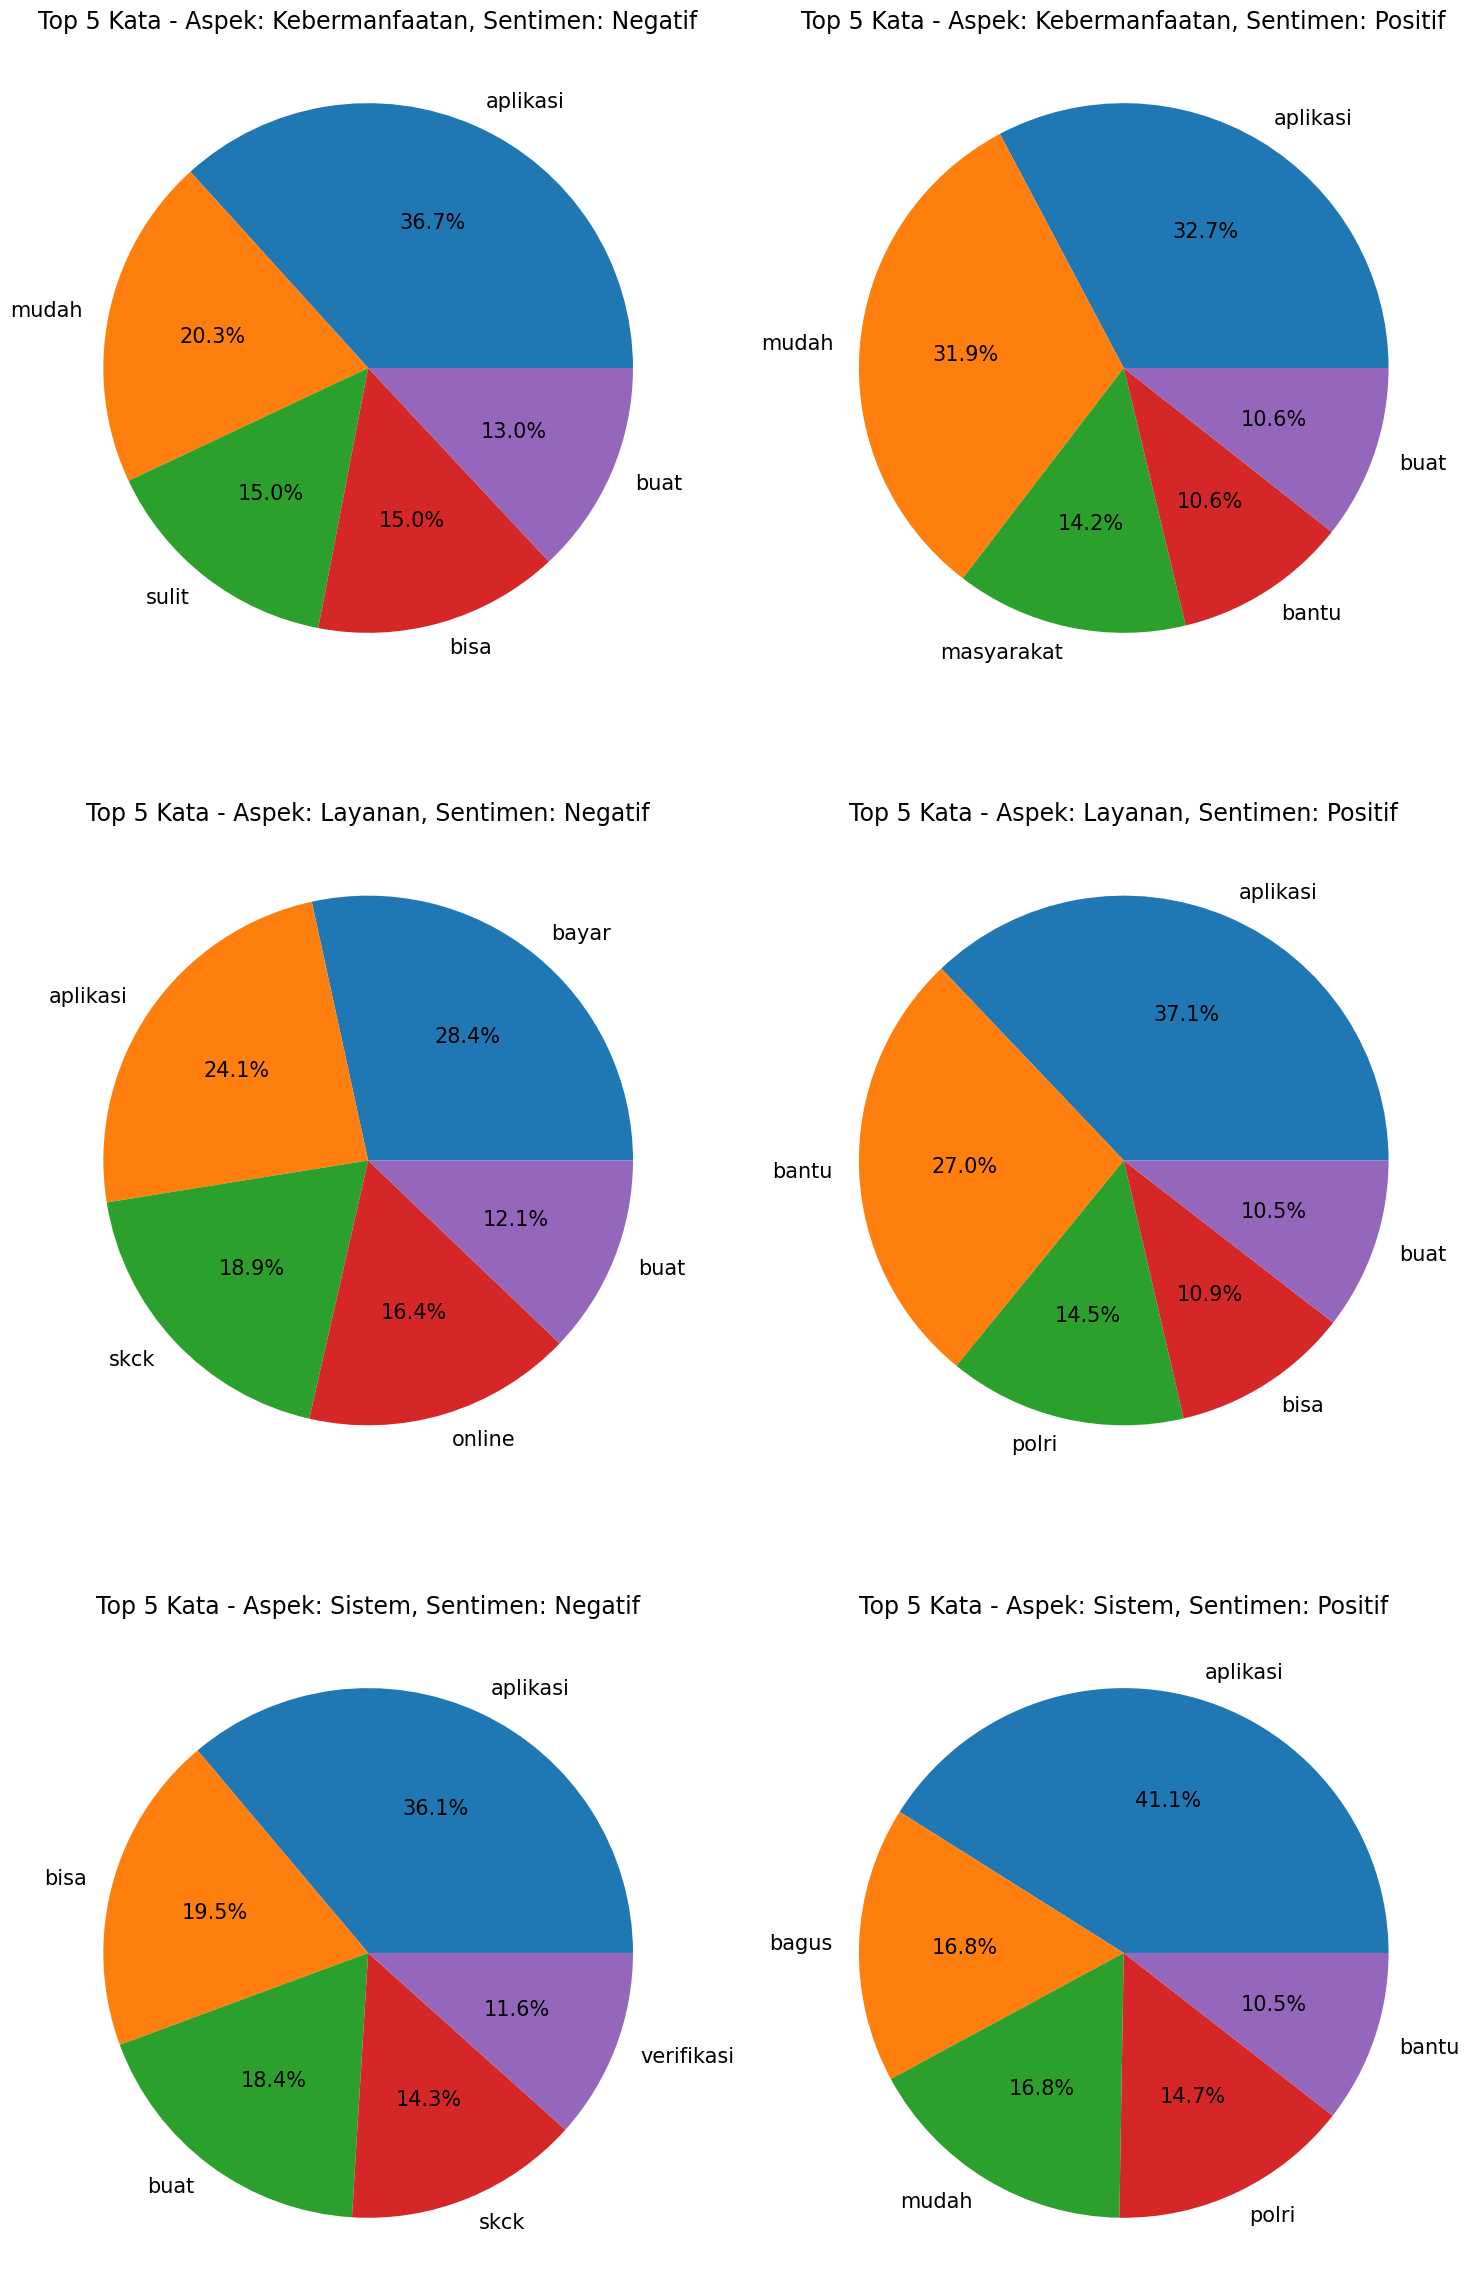

In [79]:
import matplotlib.pyplot as plt
from collections import Counter

# Langkah 1: Preprocessing
df_generate['kata'] = df_generate['Hasil Preprocess'].apply(lambda x: ' '.join(x))

# Langkah 2: Mengelompokkan kata-kata berdasarkan aspek dan sentimen
grouped_df = df_generate.groupby(['Aspek', 'Sentimen'])['kata'].apply(' '.join).reset_index()

# Langkah 3-4: Menghitung frekuensi kemunculan kata-kata dan menghitung total kata
top_words = {}
total_words = {}
exclude_words = {'tidak'}  # Kata yang akan diabaikan

for index, row in grouped_df.iterrows():
    words = [word for word in row['kata'].split() if word.lower() not in exclude_words]
    counter = Counter(words)
    total_words[(row['Aspek'], row['Sentimen'])] = len(words)
    top_words[(row['Aspek'], row['Sentimen'])] = counter.most_common(5)

# Langkah 5: Membuat dua pie chart secara horizontal berdasarkan aspek
fig, axes = plt.subplots(nrows=len(top_words)//2, ncols=2, figsize=(15, 8 * (len(top_words)//2)))

for i, (key, words) in enumerate(top_words.items()):
    aspek, sentimen = key
    total_word_count = total_words[key]

    # Tentukan posisi pie chart
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    ax.pie(
        [word[1] for word in words],  # Menghapus pembagian dengan total_word_count dan * 100
        labels=[word[0] for word in words],
        autopct='%1.1f%%',  # Persentase dengan satu desimal
        textprops={'fontsize': 15}  # Ukuran font persentase
    )
    ax.set_title(f'Top 5 Kata - Aspek: {aspek}, Sentimen: {sentimen}', fontsize=17)

plt.tight_layout()
plt.show()


## **Sebaran Data Hasil Generalisasi**

### **Sebaran Aspek**

<Figure size 1000x600 with 0 Axes>

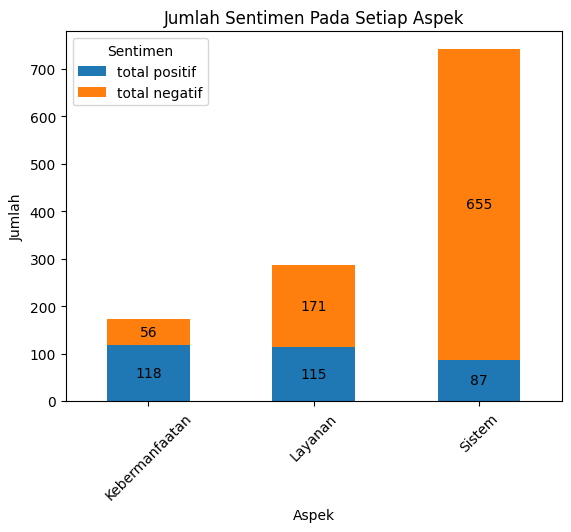

In [53]:
# Mengelompokkan data ulasan berdasarkan aspek dan sentimen
jumlah_aspek_sentimen = df_generate.groupby(['Aspek', 'Sentimen']).size().unstack(fill_value=0)

# Menambahkan kolom untuk menghitung total sentimen positif dan negatif
jumlah_aspek_sentimen['total positif'] = jumlah_aspek_sentimen['Positif']
jumlah_aspek_sentimen['total negatif'] = jumlah_aspek_sentimen['Negatif']

# Visualisasi sebaran sentimen dengan angka di tengah
plt.figure(figsize=(10, 6))
ax = jumlah_aspek_sentimen[['total positif', 'total negatif']].plot(kind='bar', stacked=True)
plt.title('Jumlah Sentimen Pada Setiap Aspek')
plt.xlabel('Aspek')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Untuk memutar label sumbu x agar lebih mudah dibaca

# Menambahkan angka di tengah batang
for i, (positif, negatif) in enumerate(zip(jumlah_aspek_sentimen['total positif'], jumlah_aspek_sentimen['total negatif'])):
  ax.text(i, positif / 2, str(positif), ha='center', va='center', fontsize=10)
  ax.text(i, positif + negatif / 2, str(negatif), ha='center', va='center', fontsize=10)

# Meletakkan legenda di bawah xlabel
plt.legend(title='Sentimen', loc='best')
plt.show()

### **Sebaran Sentimen**

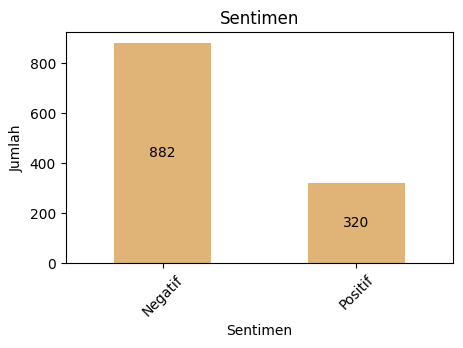

In [54]:
jumlah_sentimen = df_generate['Sentimen'].value_counts() # sebaran sentimen

# Warna Hex (misalnya, warna merah)
warna_hex = "#e0b377"

# Visualisasi sebaran sentimen dengan angka di tengah
plt.figure(figsize=(5, 3))
ax = jumlah_sentimen.plot(kind='bar', color=warna_hex)
plt.title('Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Untuk memutar label sumbu x agar lebih mudah dibaca

# Menambahkan angka di tengah batang
for i, v in enumerate(jumlah_sentimen):
    ax.text(i, v / 2, str(v), ha='center', va='center', fontsize=10)

plt.show()

## **Perbandingan dengan Algoritma Yang Lain**

### **Naive Bayes**

In [55]:
# Sentimen classification
X = np.vstack(df_ulasan['text_vector'])
y_sentimen = df_ulasan["Sentimen"]
y_aspek = df_ulasan["Aspek"]

# Split dataset for Sentimen
X_train_sentimen, X_test_sentimen, y_sentimen_train, y_sentimen_test = train_test_split(X, y_sentimen, test_size=0.2, random_state=42)

# Naive Bayes model for Sentimen
nb_model_sentimen = GaussianNB()
nb_model_sentimen.fit(X_train_sentimen, y_sentimen_train)

# Predictions for Sentimen
y_sentimen_pred = nb_model_sentimen.predict(X_test_sentimen)

# Calculate metrics for Sentimen
sentimen_metrics = {
    "Accuracy": accuracy_score(y_sentimen_test, y_sentimen_pred),
    "Precision": precision_score(y_sentimen_test, y_sentimen_pred, average='weighted'),
    "Recall": recall_score(y_sentimen_test, y_sentimen_pred, average='weighted'),
    "F1-score": f1_score(y_sentimen_test, y_sentimen_pred, average='weighted')
}

# Split dataset for Aspek
X_train_aspek, X_test_aspek, y_aspek_train, y_aspek_test = train_test_split(X, y_aspek, test_size=0.2, random_state=42)

# Naive Bayes model for Aspek
nb_model_aspek = GaussianNB()
nb_model_aspek.fit(X_train_aspek, y_aspek_train)

# Predictions for Aspek
y_aspek_pred = nb_model_aspek.predict(X_test_aspek)

# Calculate metrics for Aspek
aspek_metrics = {
    "Accuracy": accuracy_score(y_aspek_test, y_aspek_pred),
    "Precision": precision_score(y_aspek_test, y_aspek_pred, average='weighted'),
    "Recall": recall_score(y_aspek_test, y_aspek_pred, average='weighted'),
    "F1-score": f1_score(y_aspek_test, y_aspek_pred, average='weighted')
}

# Create DataFrames
sentimen_df = pd.DataFrame(sentimen_metrics, index=["Sentimen"])
aspek_df = pd.DataFrame(aspek_metrics, index=["Aspek"])

# Concatenate DataFrames
result_df = pd.concat([aspek_df, sentimen_df])
result_df

,Accuracy,Precision,Recall,F1-score
Aspek,0.6850,0.676430,0.6850,0.676121
Sentimen,0.8925,0.896714,0.8925,0.893618


### **Random Forest**

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sentimen classification
X = np.vstack(df_ulasan['text_vector'])
y_sentimen = df_ulasan["Sentimen"]
y_aspek = df_ulasan["Aspek"]

# Split dataset for Sentimen
X_train_sentimen, X_test_sentimen, y_sentimen_train, y_sentimen_test = train_test_split(X, y_sentimen, test_size=0.2, random_state=42)

# Random Forest model for Sentimen
rf_model_sentimen = RandomForestClassifier(random_state=42)
rf_model_sentimen.fit(X_train_sentimen, y_sentimen_train)

# Predictions for Sentimen
y_sentimen_pred = rf_model_sentimen.predict(X_test_sentimen)

# Calculate metrics for Sentimen
sentimen_metrics = {
    "Accuracy": accuracy_score(y_sentimen_test, y_sentimen_pred),
    "Precision": precision_score(y_sentimen_test, y_sentimen_pred, average='weighted'),
    "Recall": recall_score(y_sentimen_test, y_sentimen_pred, average='weighted'),
    "F1-score": f1_score(y_sentimen_test, y_sentimen_pred, average='weighted')
}

# Split dataset for Aspek
X_train_aspek, X_test_aspek, y_aspek_train, y_aspek_test = train_test_split(X, y_aspek, test_size=0.2, random_state=42)

# Random Forest model for Aspek
rf_model_aspek = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_aspek.fit(X_train_aspek, y_aspek_train)

# Predictions for Aspek
y_aspek_pred = rf_model_aspek.predict(X_test_aspek)

# Calculate metrics for Aspek
aspek_metrics = {
    "Accuracy": accuracy_score(y_aspek_test, y_aspek_pred),
    "Precision": precision_score(y_aspek_test, y_aspek_pred, average='weighted'),
    "Recall": recall_score(y_aspek_test, y_aspek_pred, average='weighted'),
    "F1-score": f1_score(y_aspek_test, y_aspek_pred, average='weighted')
}

# Create DataFrames
sentimen_df = pd.DataFrame(sentimen_metrics, index=["Sentimen"])
aspek_df = pd.DataFrame(aspek_metrics, index=["Aspek"])

# Concatenate DataFrames
result_df = pd.concat([aspek_df, sentimen_df])
result_df

,Accuracy,Precision,Recall,F1-score
Aspek,0.700,0.695754,0.700,0.68849
Sentimen,0.955,0.954875,0.955,0.95483


### **Logistic Regression**

In [57]:
from sklearn.linear_model import LogisticRegression

# Sentimen classification
X = np.vstack(df_ulasan['text_vector'])
y_sentimen = df_ulasan["Sentimen"]

# Split dataset for Sentimen
X_train_sentimen, X_test_sentimen, y_sentimen_train, y_sentimen_test = train_test_split(X, y_sentimen, test_size=0.2, random_state=42)

# Logistic Regression model for Sentimen
lr_model_sentimen = LogisticRegression(random_state=42)
lr_model_sentimen.fit(X_train_sentimen, y_sentimen_train)

# Predictions for Sentimen
y_sentimen_pred = lr_model_sentimen.predict(X_test_sentimen)

# Print metrics for Sentimen
sentimen_metrics = {
    "Accuracy": accuracy_score(y_sentimen_test, y_sentimen_pred),
    "Precision": precision_score(y_sentimen_test, y_sentimen_pred, average='weighted'),
    "Recall": recall_score(y_sentimen_test, y_sentimen_pred, average='weighted'),
    "F1-score": f1_score(y_sentimen_test, y_sentimen_pred, average='weighted')
}

# Aspek classification
y_aspek = df_ulasan["Aspek"]

# Split dataset for Aspek
X_train_aspek, X_test_aspek, y_aspek_train, y_aspek_test = train_test_split(X, y_aspek, test_size=0.2, random_state=42)

# Logistic Regression model for Aspek
lr_model_aspek = LogisticRegression(random_state=42)
lr_model_aspek.fit(X_train_aspek, y_aspek_train)

# Predictions for Aspek
y_aspek_pred = lr_model_aspek.predict(X_test_aspek)

# Print metrics for Aspek
aspek_metrics = {
    "Accuracy": accuracy_score(y_aspek_test, y_aspek_pred),
    "Precision": precision_score(y_aspek_test, y_aspek_pred, average='weighted'),
    "Recall": recall_score(y_aspek_test, y_aspek_pred, average='weighted'),
    "F1-score": f1_score(y_aspek_test, y_aspek_pred, average='weighted')
}

# Create DataFrames
sentimen_df = pd.DataFrame(sentimen_metrics, index=["Sentimen"])
aspek_df = pd.DataFrame(aspek_metrics, index=["Aspek"])

# Concatenate DataFrames
result_df = pd.concat([aspek_df, sentimen_df])
result_df

,Accuracy,Precision,Recall,F1-score
Aspek,0.7675,0.767364,0.7675,0.762061
Sentimen,0.9600,0.960000,0.9600,0.960000
